In [374]:
import numpy as np
from matplotlib import pyplot as plt
import xarray
import gsw
import xarray as xr
from ctd2xray import cchdo
%matplotlib inline

In [494]:
ds = xr.open_mfdataset('/home/cjp2164/tutorial/section.nc')
ds

<xarray.Dataset>
Dimensions:           (pressure_i: 600, time: 86)
Coordinates:
  * pressure_i        (pressure_i) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 ...
    longitude         (time) float64 168.1 168.4 168.4 168.5 168.6 169.1 ...
  * time              (time) datetime64[ns] 2011-02-22T21:12:00 ...
    latitude          (time) float64 -70.65 -70.5 -70.47 -70.44 -70.36 -70.1 ...
Data variables:
    woce_time         (time) int32 2112 9 212 513 947 1415 1917 106 645 1926 ...
    rho               (pressure_i, time) float64 1.027e+03 1.028e+03 ...
    temperature_i     (pressure_i, time) float64 -1.363 -1.218 -1.298 -1.342 ...
    oxygen_i          (pressure_i, time) float64 320.2 338.8 340.6 343.0 ...
    salinity_i        (pressure_i, time) float64 34.13 34.17 34.14 34.12 ...
    CT                (pressure_i, time) float64 -1.359 -1.215 -1.294 -1.339 ...
    woce_date         (time) int32 20110222 20110223 20110223 20110223 ...
    pressure_QC_i     (pressure_i, time) float64 2.0

In [495]:
adt = xr.open_mfdataset('/home/cjp2164/tutorial/adt.nc')

In [496]:
deltalat=ds.latitude.diff('time')
deltalon=ds.longitude.diff('time')
R=6378000 #radius of earth in m

dy=((np.pi*R)/180)*deltalat
dx=((np.pi*R)/180)*deltalon * np.cos((ds.latitude[1:])*(np.pi/180))

dL=np.sqrt(dx**2+dy**2)
dist=np.sum(dL)
dist/1000
l = np.cumsum(dL).rename('l').reset_coords(drop=True)
l.reset_coords()

<xarray.Dataset>
Dimensions:  (time: 85)
Coordinates:
  * time     (time) datetime64[ns] 2011-02-23T00:09:00 2011-02-23T02:12:00 ...
Data variables:
    l        (time) float64 1.995e+04 2.46e+04 2.811e+04 3.871e+04 7.348e+04 ...

In [497]:
ds['dist'] = l
ds.dist[0] = 0.
ds = ds.swap_dims({'time': 'dist'})

In [498]:
adt['dist'] = xr.DataArray(l.values, dims='points',
                           coords={'points': adt.points[1:]})
adt.dist[0] = 0.
adt = adt.swap_dims({'points': 'dist'})
ds['adt'] = adt.adt.reset_coords(drop=True)

In [499]:
import scipy
from scipy import integrate
from scipy.integrate import cumtrapz

ds['delta'] = ds.rho**-1
ds['delta_anom'] = ds.delta - ds.delta.mean(dim='dist')

pres_pascal = 10000*ds.pressure_i
geo_anom = -scipy.integrate.cumtrapz(ds.delta_anom, x=pres_pascal, axis=0, initial=0)
ds['D'] = xr.DataArray(geo_anom/9.8, dims=['pressure_i', 'dist'],
                      coords={'dist': ds.dist,
                              'pressure_i': ds.pressure_i})

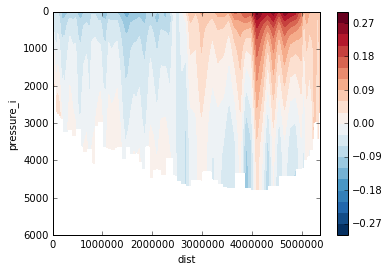

In [500]:
adt_anom = ds.adt - ds.adt.mean()
(ds.D + adt_anom).plot.contourf(levels=20,yincrease=False)

In [502]:
n_D=ds.D+adt_anom
f=gsw.f(ds.latitude)
n_D

<xarray.DataArray (pressure_i: 600, dist: 86)>
dask.array<elemwise-6ea98bd254ae0d8b706b0eba9b84df38, shape=(600, 86), chunks=((600,), (86,)), dtype=float64>
Coordinates:
  * pressure_i  (pressure_i) float64 5.0 15.0 25.0 35.0 45.0 55.0 65.0 75.0 ...
    longitude   (dist) float64 168.1 168.4 168.4 168.5 168.6 169.1 169.5 ...
    time        (dist) datetime64[ns] 2011-02-22T21:12:00 ...
    latitude    (dist) float64 -70.65 -70.5 -70.47 -70.44 -70.36 -70.1 ...
  * dist        (dist) float64 0.0 1.995e+04 2.46e+04 2.811e+04 3.871e+04 ...

In [503]:
n_D_smooth = n_D.load().rolling(dist=5).mean(dim='dist')

vg=(9.8/f[1:])*(n_D_smooth.diff('dist'))/n_D_smooth.dist.diff('dist')
ds['vg']=vg.reset_coords(drop=True)

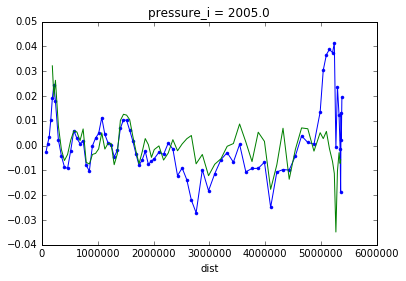

In [504]:
vg[0].plot(marker='.')
vg[200].plot()

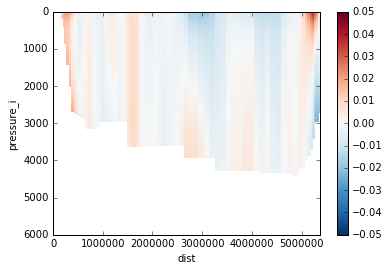

In [505]:
ds.vg.load()
ds.vg.rolling(dist=5).mean(dim='dist').plot(yincrease=False, vmax=0.05)

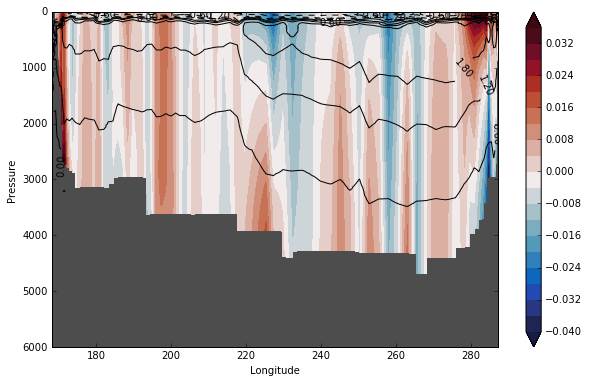

In [515]:
import cmocean
fig, ax = plt.subplots(figsize=(10,6),subplot_kw={'axisbg': '0.3'})

con=ax.contourf(ds.longitude,ds.pressure_i,ds.vg,np.arange(-.04,.04,.004),
                cmap=cmocean.cm.balance,extend='both')
con2=ax.contour(ds.longitude,ds.pressure_i,ds.temperature_i,colors='k')
ax.clabel(con2, fmt='%4.2f')
ax.invert_yaxis()
cbar=fig.colorbar(con)
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure')

In [477]:
ds2 = xr.open_mfdataset('/home/cjp2164/tutorial/section2.nc')

deltalat2=ds2.latitude.diff('time')
deltalon2=ds2.longitude.diff('time')
R=6378000 #radius of earth in m

dy2=((np.pi*R)/180)*deltalat2
dx2=((np.pi*R)/180)*deltalon2 * np.cos((ds2.latitude[1:])*(np.pi/180))

dL2=np.sqrt(dx2**2+dy2**2)
dist2=np.sum(dL2)
dist2/1000
l2 = np.cumsum(dL2).rename('l2').reset_coords(drop=True)
l2.reset_coords()

<xarray.Dataset>
Dimensions:  (time: 98)
Coordinates:
  * time     (time) datetime64[ns] 1992-02-22T23:44:00 1992-02-23T10:54:00 ...
Data variables:
    l2       (time) float64 5.583e+04 1.046e+05 1.192e+05 1.228e+05 ...

In [478]:
ds2['dist'] = l2
ds2.dist[0] = 0.
ds2 = ds2.swap_dims({'time': 'dist'})

In [479]:
adt2 = xr.open_mfdataset('/home/cjp2164/tutorial/adt2.nc')

In [480]:
adt2['dist'] = xr.DataArray(l2.values, dims='points',
                           coords={'points': adt2.points[1:]})
adt2.dist[0] = 0.
adt2 = adt2.swap_dims({'points': 'dist'})
ds2['adt'] = adt2.adt.reset_coords(drop=True)

In [481]:
ds2['delta'] = ds2.rho**-1
ds2['delta_anom'] = ds2.delta - ds2.delta.mean(dim='dist')

pres_pascal2 = 10000*ds2.pressure_i
geo_anom2 = -scipy.integrate.cumtrapz(ds2.delta_anom, x=pres_pascal, axis=0, initial=0)
ds2['D'] = xr.DataArray(geo_anom2/9.8, dims=['pressure_i', 'dist'],
                      coords={'dist': ds2.dist,
                              'pressure_i': ds2.pressure_i})

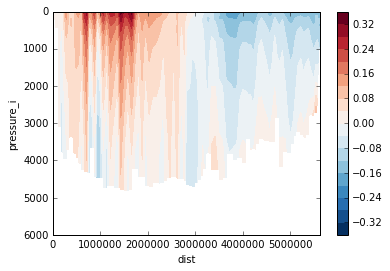

In [482]:
adt_anom2 = adt2.adt - adt2.adt.mean()
(ds2.D + adt_anom2).plot.contourf(levels=20,yincrease=False)

In [485]:
n_D2=ds2.D+adt_anom2
f=gsw.f(ds2.latitude)

n_D_smooth2 = n_D2.load().rolling(dist=5).mean(dim='dist')

vg2=(9.8/f[1:])*(n_D_smooth2.diff('dist'))/n_D_smooth2.dist.diff('dist')
ds2['vg']=vg2.reset_coords(drop=True)

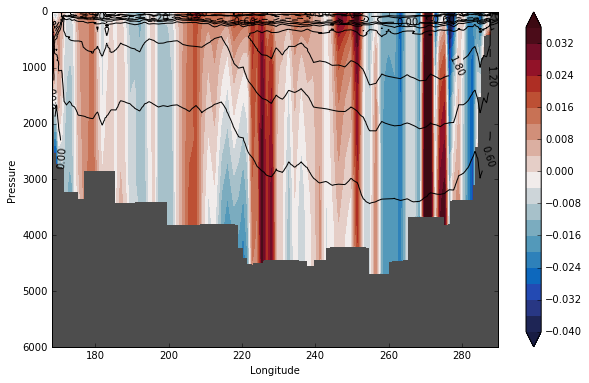

In [514]:
fig, ax = plt.subplots(figsize=(10,6),subplot_kw={'axisbg': '0.3'})

con=ax.contourf(ds2.longitude,ds2.pressure_i,ds2.vg,np.arange(-.04,.04,.004),
                cmap=cmocean.cm.balance,extend='both')
con2=ax.contour(ds2.longitude,ds2.pressure_i,ds2.temperature_i,colors='k')
ax.clabel(con2, fmt='%4.2f')
ax.invert_yaxis()
fig.colorbar(con)
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure') 

In [419]:
#x,y=np.meshgrid(ds.longitude,ds.latitude)
z=ds.vg[0:1000,:].mean(dim='pressure_i')

#plt.contourf(ds.longitude,ds.latitude,z)

In [571]:
import scipy.io
mat = scipy.io.loadmat('S4P_2011_LADCP.mat')

depth=mat['depth']
lat=mat['lat']
lon=mat['lon']+360
u=mat['u']
v=mat['v']

In [572]:
slice1=u[0:44,:]
slice2=u[94:101,:]
slice3=u[103:None,:]

u_new=np.concatenate((slice1,slice2,slice3),axis=0)

slice4=v[0:44,:]
slice5=v[94:101,:]
slice6=v[103:None,:]

v_new=np.concatenate((slice4,slice5,slice6),axis=0)

slice7=lon[0:44]
slice8=lon[94:101]
slice9=lon[103:None]

lon_new=np.concatenate((slice7,slice8,slice9),axis=0)

slice10=lat[0:44]
slice11=lat[94:101]
slice12=lat[103:None]

lat_new=np.concatenate((slice10,slice11,slice12),axis=0)

(168, 287)

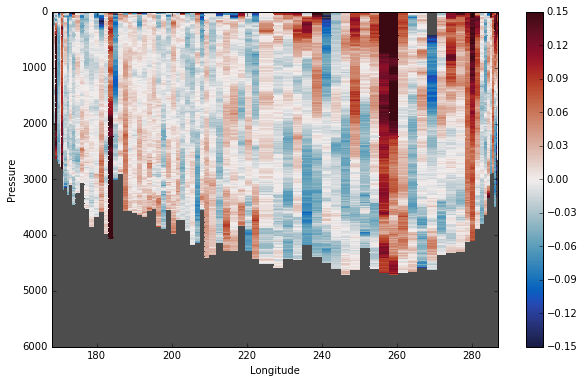

In [598]:
x,y=np.meshgrid(lon_new,depth)
fig, ax = plt.subplots(figsize=(10,6),subplot_kw={'axisbg': '0.3'})

con=ax.pcolor(x,y,u_new.T,cmap=cmocean.cm.balance,vmin=-.15,vmax=.15)
con.cmap.set_under('0.3')
ax.invert_yaxis()
fig.colorbar(con)
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure')
ax.set_xlim([168, 287])

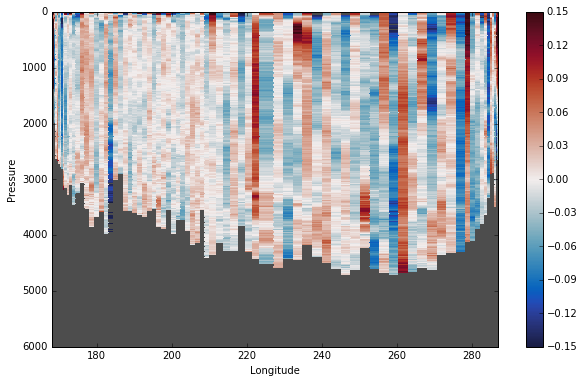

In [595]:
x,y=np.meshgrid(lon_new,depth)
fig, ax = plt.subplots(figsize=(10,6),subplot_kw={'axisbg': '0.3'})

con=ax.pcolor(x,y,v_new.T,cmap=cmocean.cm.balance,vmin=-.15,vmax=.15)
con.cmap.set_under('0.3')
ax.invert_yaxis()
fig.colorbar(con)
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure')
ax.set_xlim([168, 287])
ax.set_axis_bgcolor('0.3')